In [2]:
from scipy.io import loadmat
from elephant.statistics import instantaneous_rate
import neo
from quantities import Hz, s, ms

data=loadmat('/home/maria/Documents/NeuralDataAnalysis/Amygdala/RRITSpksBehData (2).mat')
data['RRITSpksBehData']

array([[array(['Subject'], dtype='<U7'),
        array(['FileRoot'], dtype='<U8'),
        array(['UnitKey'], dtype='<U7'), ...,
        array(['TrialType'], dtype='<U9'),
        array(['TrialScore'], dtype='<U10'),
        array(['Behaviors'], dtype='<U9')],
       [array(['RRIT16'], dtype='<U6'),
        array(['2016-03-02_RRIT16_Singles10'], dtype='<U27'),
        array(['RRIT16_Singles_10_2_2'], dtype='<U21'), ...,
        array([[array(['CS-R2'], dtype='<U5')],
       [array(['CS-S2'], dtype='<U5')],
       [array(['CS-S3'], dtype='<U5')],
       [array(['CS-R1'], dtype='<U5')],
       [array(['CS-S1'], dtype='<U5')],
       [array(['CS-S2'], dtype='<U5')],
       [array(['CS-S3'], dtype='<U5')],
       [array(['CS-R2'], dtype='<U5')],
       [array(['CS-R1'], dtype='<U5')],
       [array(['CS-S1'], dtype='<U5')],
       [array(['CS-S2'], dtype='<U5')],
       [array(['CS-R1'], dtype='<U5')],
       [array(['CS-S1'], dtype='<U5')],
       [array(['CS-R2'], dtype='<U5')],
       [

In [ ]:
'''
Here is a brief description of each column:
Subject - the subject ID given to each rat recorded in the study
FileRoot - the name of the file for each recording day (date_subjectID_sessionID)
UnitKey - a unique identifier for each recorded unit
SpikeTimeStamps - the time of each spike in seconds 
MeanFiringRate - mean firing rate across the entire recording session in Hz for each unit
Location - the histological identification where the unit was recorded (STR = striatum; LA = lateral nucleus of the amygdala; BL = basolateral nucleus of the amygdala)
CellClass - the classification of the unit as a putative principal neuron (PN) or interneuron (ITN)
TrialNum -  the number of the trials recorded in the given session
TrialOnset - the time of the CS onset for each trial in seconds
TrialType - the type of stimulus presented for each trial (CS-R1, CS-R2, CS-S1, CS-S2, CS-S3)
TrialScore - indicates whether the animal performed correctly for the given trial (i.e.-correctly retrieved reward or avoided shock)
Behaviors - the behaviors observed for each trial along with the behavior start and end time (in seconds) for each one. Note there are some behaviors listed that were not analyzed for this paper.

'''

In [3]:
data['RRITSpksBehData'][0][:]

array([array(['Subject'], dtype='<U7'), array(['FileRoot'], dtype='<U8'),
       array(['UnitKey'], dtype='<U7'),
       array(['SpikeTimeStamps'], dtype='<U15'),
       array(['MeanFiringRate'], dtype='<U14'),
       array(['Location'], dtype='<U8'),
       array(['CellClass'], dtype='<U9'),
       array(['TrialNum'], dtype='<U8'),
       array(['TrialOnset'], dtype='<U10'),
       array(['TrialType'], dtype='<U9'),
       array(['TrialScore'], dtype='<U10'),
       array(['Behaviors'], dtype='<U9')], dtype=object)

In [24]:
data['RRITSpksBehData'][:].shape

(762, 12)

In [96]:
data['RRITSpksBehData'][30,11][0]

array([array([[array(['Reward Approach'], dtype='<U15'), array([[72.17473421]]),
        array([[74.10736667]])],
       [array(['Reward Anticipation'], dtype='<U19'),
        array([[74.50776667]]), array([[79.38233333]])]], dtype=object)],
      dtype=object)

In [89]:
import numpy as np
#print(data['RRITSpksBehData'][:,2])
import elephant.conversion as conv
import neo
import quantities as pq
from elephant.statistics import instantaneous_rate,time_histogram
import neo
from elephant import kernels
from quantities import Hz, s, ms
import matplotlib.pyplot as plt


def get_spks(animal='RRIT38'):
    one_unit_lst=[]
    for j in range(0,762):
        if data['RRITSpksBehData'][:,2][j][0][0:6]=='RRIT38':
            #print(j)
            one_unit_lst.append(j)
    #for j in range(0,762):
        #print(data['RRITSpksBehData'][:,2][j][0])
    an_ind_BL=[]
    an_ind_LA=[]
    for j in range(0,len(one_unit_lst)):
        if data['RRITSpksBehData'][:,5][j]=='LA':
            an_ind_LA.append(one_unit_lst[j])
        if data['RRITSpksBehData'][:,5][j]=='BL':
            an_ind_BL.append(one_unit_lst[j])
            
    spks_BL=[]
    spks_LA=[]
    for j in range(0,len(an_ind_BL)):
        spiketrain_BL=data['RRITSpksBehData'][:,3][an_ind_BL[j]].flatten()
        elephant_spks_BL=neo.SpikeTrain(spiketrain_BL, units='sec', t_stop=np.max(spiketrain_BL)*pq.s)
        binned_spk_tr = conv.BinnedSpikeTrain(elephant_spks_BL, binsize=0.5*pq.s,
                                t_start=0*pq.s,t_stop=500*pq.s)
        binned_spk_tr=binned_spk_tr.to_array()
        spks_BL.append(binned_spk_tr.flatten())
    for j in range(0,len(an_ind_LA)):
        spiketrain_LA=data['RRITSpksBehData'][:,3][an_ind_LA[j]].flatten()
        elephant_spks_LA=neo.SpikeTrain(spiketrain_LA, units='sec', t_stop=np.max(spiketrain_LA)*pq.s)
        binned_spk_tr = conv.BinnedSpikeTrain(elephant_spks_LA, binsize=0.5*pq.s,
                                t_start=0*pq.s,t_stop=500*pq.s)
        binned_spk_tr=binned_spk_tr.to_array()
        spks_LA.append(binned_spk_tr.flatten())
    
    return np.array(spks_BL),np.array(spks_LA)
spks_BL,spks_LA=get_spks()
print(spks_BL.shape)

(74, 1000)


(1000,)


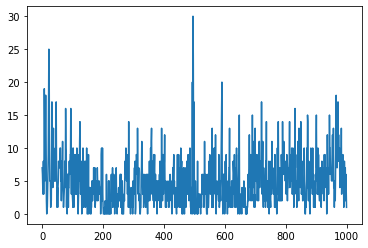

In [81]:
def align_spks(spks_BL,spks_LA):
    '''
    len_lst=[]
    for j in range(len(spks_BL)):
        len_lst.append(spks_BL[j].shape[1])
    print(len_lst)
    len_lst=[]
    for j in range(len(spks_LA)):
        len_lst.append(spks_LA[j].shape[1])
    print(len_lst)
    '''
    
    

align_spks(spks_BL,spks_LA) 
print(spks_BL[0][:].shape)
plt.plot(spks_BL[0][:].flatten())

In [90]:
from sklearn.linear_model import Ridge

import numpy as np
from sklearn.linear_model import Ridge
import numpy as np
import os , csv
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd


#Sklearn imports
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

import seaborn as sns

from scipy.linalg import null_space

#Test-train split
from sklearn.model_selection import train_test_split
#indices=range(75)
BL_train, BL_test, LA_train,LA_test=train_test_split(spks_BL.T,spks_LA.T,test_size=0.33, random_state=42)

from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#scaler.fit(BL_train)
#BL_train=scaler.transform(BL_train)+0.0001
#BL_test=scaler.transform(BL_test)+0.0001

#scaler = StandardScaler()
#scaler.fit(LA_train)
#LA_train=scaler.transform(LA_train)+0.0001
#LA_test=scaler.transform(LA_test)+0.0001

In [68]:
np.where(np.isnan(BL_train)==True)

(array([], dtype=int64), array([], dtype=int64))

In [86]:
np.std(LA_test)

3.672749078859778

In [87]:
LA_test.shape
LA_train.shape
BL_train.shape

(670, 74)

In [47]:
pca_LA=PCA(n_components=10)
pca_BL=PCA(n_components=5)

pcs_LA=pca_LA.fit_transform(LA_train)
pcs_BL=pca_BL.fit_transform(BL_train)

pcs_LA_test=pca_LA.transform(LA_test)
pcs_BL_test=pca_BL.transform(BL_test)

In [30]:
print(pca_LA.explained_variance_)
pca_BL.explained_variance_

[1.87521331 1.41626843 1.28913136 1.20323685 1.12714536]


array([3.56097728, 2.40815401, 2.0407408 , 1.85559621, 1.7771167 ,
       1.66478653, 1.64331445, 1.59976779, 1.57843676, 1.44245882])

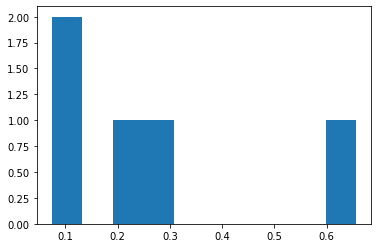

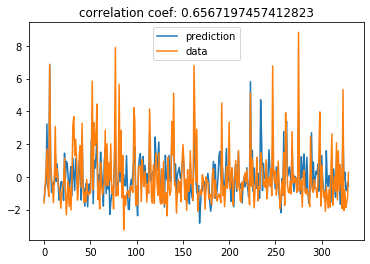

In [92]:
def ridge_regression(train_inputs,train_outputs,test_inputs,test_outputs,regularization_parameter=10):

    from_front_to_mid_reg=Ridge(regularization_parameter)

    from_front_to_mid_reg.fit(train_inputs,train_outputs)
    prediction=from_front_to_mid_reg.predict(test_inputs)

    pcs_corr=[]
    for j in range(0,test_outputs.shape[1]):
        #print(np.corrcoef(prediction[:,j],test_outputs[:,j])[0,1])
        pcs_corr.append(np.corrcoef(prediction[:,j],test_outputs[:,j])[0,1])

    plt.hist(pcs_corr)
    plt.show()

    ind_to_plot=np.argsort(pcs_corr)[-1]
    #ind_to_plot=2
    plt.plot(prediction[:,ind_to_plot],label='prediction')
    plt.plot(test_outputs[:,ind_to_plot],label='data')
    plt.title('correlation coef: '+str(pcs_corr[ind_to_plot]))
    plt.legend()
    
    return from_front_to_mid_reg
    
from_front_to_mid_reg=ridge_regression(pcs_LA,pcs_BL,pcs_LA_test,pcs_BL_test)
#from_front_to_mid_reg=ridge_regression(LA_train,BL_train,LA_test,BL_test)
#from_front_to_mid_reg=ridge_regression(pcs_BL,pcs_LA,pcs_BL_test,pcs_LA_test)

In [123]:
def extract_behavior():
    one_unit_lst=[]
    for j in range(0,762):
        if data['RRITSpksBehData'][:,2][j][0][0:6]=='RRIT38':
            #print(j)
            one_unit_lst.append(j)
    #for j in range(0,762):
        #print(data['RRITSpksBehData'][:,2][j][0])
    an_ind_BL=[]
    an_ind_LA=[]
    for j in range(0,len(one_unit_lst)):
        if data['RRITSpksBehData'][:,5][j]=='LA':
            an_ind_LA.append(one_unit_lst[j])
        if data['RRITSpksBehData'][:,5][j]=='BL':
            an_ind_BL.append(one_unit_lst[j])
    behavior=data['RRITSpksBehData'][an_ind_BL[0],11]
    
    beh_dct={}
    beh_lst=[]
    time_lst=[]
    for ind in range(len(behavior)):
        beh=behavior[ind].flatten()
        for ind2 in range(len(beh)):
            beh_lst.append(beh[ind2][0].flatten())

            #print(beh[ind2][0].flatten()[0][0])
            beh_dct[beh[ind2][0].flatten()[0][0]]=[]
    #print(beh_lst)
    for b in beh_lst:
        #print(b)
        beh_dct[b.flatten()[0][0]].append([b.flatten()[1][0][0],b.flatten()[2][0][0]])
        
    #print(beh_lst)
    print(beh_dct)
    '''
        spks_BL=[]
        spks_LA=[]
        for j in range(0,len(an_ind_BL)):
            spiketrain_BL=data['RRITSpksBehData'][:,3][an_ind_BL[j]].flatten()
            elephant_spks_BL=neo.SpikeTrain(spiketrain_BL, units='sec', t_stop=np.max(spiketrain_BL)*pq.s)
            binned_spk_tr = conv.BinnedSpikeTrain(elephant_spks_BL, binsize=0.5*pq.s,
                                    t_start=0*pq.s,t_stop=500*pq.s)
            binned_spk_tr=binned_spk_tr.to_array()
            spks_BL.append(binned_spk_tr.flatten())
        for j in range(0,len(an_ind_LA)):
            spiketrain_LA=data['RRITSpksBehData'][:,3][an_ind_LA[j]].flatten()
            elephant_spks_LA=neo.SpikeTrain(spiketrain_LA, units='sec', t_stop=np.max(spiketrain_LA)*pq.s)
            binned_spk_tr = conv.BinnedSpikeTrain(elephant_spks_LA, binsize=0.5*pq.s,
                                    t_start=0*pq.s,t_stop=500*pq.s)
            binned_spk_tr=binned_spk_tr.to_array()
            spks_LA.append(binned_spk_tr.flatten())
    
    return np.array(spks_BL),np.array(spks_LA)
    '''
extract_behavior()    

def extract_stimuli():
    pass

{'Reward Approach': [[93.16000000000001, 95.52000000000001], [133.2, 134.88], [315.28, 318], [504.12, 507], [601.24, 603.44], [861.9739999999999, 864.9613793103448], [988.32, 990.0551351351352], [1541.96, 1545.28], [1589.1200000000001, 1593.8000000000002], [1804.9733333333334, 1809.9191666666666], [2114.6800000000003, 2119.252765957447], [2256.72, 2260.6400000000003], [2390.4846153846156, 2394.48], [2609.4, 2613.8], [2845.04, 2849.04], [4270.240000000001, 4276.16], [4403.618666666667, 4407.04], [5095.4400000000005, 5099.04], [5511.840000000001, 5515.129230769231], [5739.719999999999, 5747.039999999999], [6014.4, 6019.200000000001], [6367.360000000001, 6372.490980392156], [6993.638, 6997.4400000000005], [7079.6, 7083.12]], 'Passive Avoidance': [[179.52, 186.64000000000001], [222.88, 242.88000000000002], [404.24, 424.24], [454.16, 474.1551219512195], [543.8800000000001, 559.967619047619], [727.52, 747.52], [775.6392000000001, 789.0000000000001], [903.28, 923.2416326530612], [1132.2194871